In [1]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
%matplotlib inline

# Data Setup

In [2]:
dataset = ImageFolder('/content/drive/MyDrive/csc420_a2/DBIsubset')

SDDdataset = ImageFolder('/content/drive/MyDrive/csc420_a2/SDDsubset')
print(len(SDDdataset))
print(len(SDDdataset.classes))

1233
7


In [3]:
breeds = []
for n in SDDdataset.classes:
    breeds.append(n)

print(breeds)

['bernese_mountain_dog', 'border_collie', 'chihuahua', 'golden_retriever', 'labrador_retriever', 'pug', 'siberian_husky']


In [4]:
from PIL import Image
# function to remove EXIF images
def remove_exif(image_name, count):
    image = Image.open(image_name)
    if not image.getexif():
        return
    print('removing EXIF from', image_name, '...')
    count+=1
    data = list(image.getdata())
    image_without_exif = Image.new(image.mode, image.size)
    image_without_exif.putdata(data)

    image_without_exif.save(image_name)
    print(count)
for n in dataset.classes:
      name = '/content/drive/MyDrive/csc420_a2/DBIsubset/'+n
      for i in os.listdir(name):
          remove_exif(name+'/'+i, 0)

for n in SDDdataset.classes:
      name = '/content/drive/MyDrive/csc420_a2/SDDsubset/'+n
      for i in os.listdir(name):
          remove_exif(name+'/'+i, 0)


In [5]:
print(len(SDDdataset))
print(len(SDDdataset.classes))

1233
7


In [6]:
random_seed = 45
torch.manual_seed(random_seed);

test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size


train_size, val_size, test_size

(408, 45, 193)

In [7]:
# for sdd dataset
random_seed = 45
torch.manual_seed(random_seed);

test_pct = 0.3
sdd_test_size = int(len(SDDdataset)*test_pct)
sdd_dataset_size = len(SDDdataset) - sdd_test_size

val_pct = 0.1
sdd_val_size = int(sdd_dataset_size*val_pct)
sdd_train_size = sdd_dataset_size - sdd_val_size


sdd_train_size, sdd_val_size, sdd_test_size

(778, 86, 369)

In [8]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
print(train_ds[6])

(<PIL.Image.Image image mode=RGB size=1600x1200 at 0x7FE0B2037160>, 3)


In [9]:
# for sdd dataset
sdd_train_ds, sdd_val_ds, sdd_test_ds = random_split(SDDdataset, [sdd_train_size, sdd_val_size, sdd_test_size])
len(sdd_train_ds), len(sdd_val_ds), len(sdd_test_ds)

(778, 86, 369)

siberian_husky
<class 'PIL.Image.Image'>


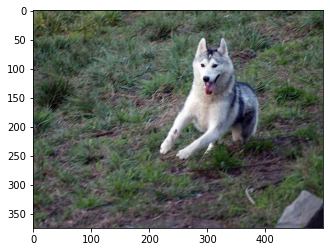

In [10]:
img, label = sdd_train_ds[6]
print(dataset.classes[label])
plt.imshow(img)
print(type(img))

In [11]:
class DogBreedDataset(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
            return img, label

In [12]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
#    transforms.Resize((224, 224)),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
    
])


val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

In [13]:
train_dataset = DogBreedDataset(train_ds, train_transform)
val_dataset = DogBreedDataset(val_ds, val_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)
DBIdataset = DogBreedDataset(dataset, test_transform)

sdd_train_dataset = DogBreedDataset(sdd_train_ds, train_transform)
sdd_val_dataset = DogBreedDataset(sdd_val_ds, val_transform)
sdd_test_dataset = DogBreedDataset(sdd_test_ds, test_transform)
sdd_dataset = DogBreedDataset(SDDdataset, test_transform)
     

6


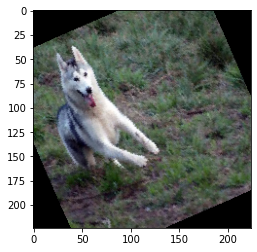

In [14]:
img, label = sdd_train_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

In [15]:
batch_size =64

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)
DBI_dl = DataLoader(DBIdataset, batch_size*2, num_workers=2, pin_memory=True)

In [16]:
# SDD dataloaders
sdd_train_dl = DataLoader(sdd_train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
sdd_val_dl = DataLoader(sdd_val_dataset, batch_size*2, num_workers=2, pin_memory=True)
sdd_test_dl = DataLoader(sdd_test_dataset, batch_size*2, num_workers=2, pin_memory=True)
SDD_dl = DataLoader(sdd_dataset, batch_size*2, num_workers=2, pin_memory=True)


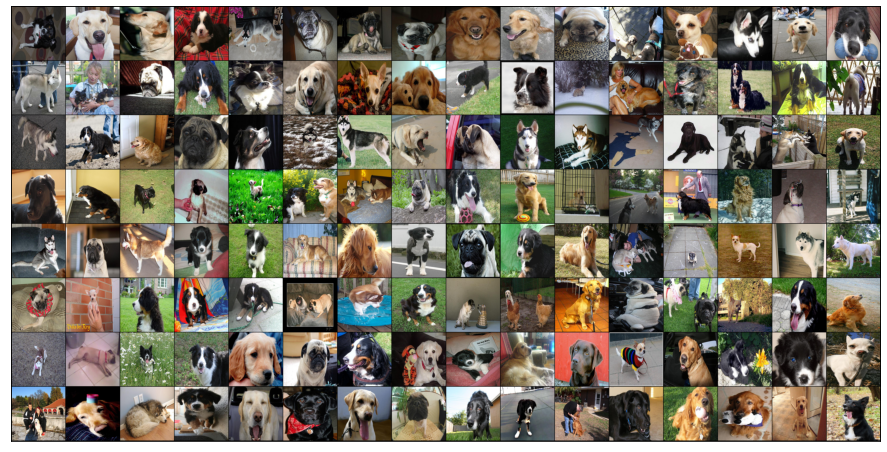

In [17]:
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break
show_batch(sdd_test_dl)

In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [19]:
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        return loss
    
    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
    
    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        
    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))

In [20]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

In [21]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

In [22]:
from tqdm.notebook import tqdm

In [23]:
def get_lr(optimizer):
      for param_group in optimizer.param_groups:
        return param_group['lr']
        

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, test_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        
        # Training phase
        model.train()       
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            
            # calculates gradients
            loss.backward()
            
            # check gradient clipping 
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            # perform gradient descent and modifies the weights
            optimizer.step()
            
            # reset the gradients
            optimizer.zero_grad()
            
            # record and update lr
            lrs.append(get_lr(optimizer))
            
            # modifies the lr value
            sched.step()
            
        # Validation phase
        result = evaluate(model, val_loader, train_loader, test_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
        
    return history
        
    

@torch.no_grad()
def evaluate(model, val_loader, train_loader, test_loader):
    # I added train accuracy here
    model.eval()
    val_outputs = [model.validation_step(batch) for batch in val_loader]
    train_outputs = [model.validation_step(batch) for batch in train_loader]
    test_outputs = [model.validation_step(batch) for batch in test_loader]

    output_val = model.validation_epoch_end(val_outputs)
    output_train = model.validation_epoch_end(train_outputs)
    output_test = model.validation_epoch_end(test_outputs)
    output = output_val
    output['test_acc'] = output_test['val_acc']
    output['train_acc'] = output_train['val_acc']
    return output


# CNN model

In [31]:
class DogBreedClassificationCNN(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = nn.Sequential(
          

            nn.Conv2d(3, 16, 3, stride=1, padding=1),   # 224 * 224 * 16
            nn.ReLU(),                                   
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, stride=1, padding=1),  # 224 * 224 * 16
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # 112 * 112 * 16
            
            nn.Conv2d(16, 8, 3, stride=1, padding=1),   # 112 * 112 * 8
            nn.ReLU(), 
            nn.BatchNorm2d(8),
            
            nn.Conv2d(8, 8, 3, stride=1, padding=1),    # 112 * 112* 8
            nn.ReLU(),
            nn.MaxPool2d(2,2),                          # 56 * 56* 8
            
            nn.Flatten(),
            nn.Linear(56*56*8, 32),
            nn.ReLU(),
            nn.Linear(32, 7),
            
            nn.LogSoftmax(dim = 1),
        )
    
    def forward(self, xb):
        return self.network(xb)
     

In [32]:
model = DogBreedClassificationCNN()
model

DogBreedClassificationCNN(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=25088, out_features=32, bias=True)
    (14): ReLU()
    (15): Linear(in_features=32, out_features=7, bias=True)
    (16): LogSoftmax(dim=1)
  )
)

In [33]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
DBI_dl = DeviceDataLoader(DBI_dl, device)

sdd_train_dl = DeviceDataLoader(sdd_train_dl, device)
sdd_val_dl = DeviceDataLoader(sdd_val_dl, device)
sdd_test_dl = DeviceDataLoader(sdd_test_dl, device)
SDD_dl = DeviceDataLoader(SDD_dl, device)

# moving model to gpu
model = to_device(model, device);

cpu


In [89]:
from inspect import modulesbyfile
def try_batch(dl):
    for imgs, labels in dl:
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = model(imgs)                            # Change model object here
        print("outs.shape :", outs.shape)
        print("outs : ", outs)
        break
        
try_batch(train_dl)

images shape :  torch.Size([64, 3, 224, 224])
labels :  tensor([0, 3, 0, 3, 4, 6, 6, 1, 3, 3, 4, 6, 4, 6, 3, 1, 5, 6, 3, 5, 5, 5, 5, 6,
        2, 5, 0, 0, 3, 2, 0, 5, 0, 3, 2, 6, 2, 5, 6, 5, 1, 4, 0, 6, 2, 6, 3, 4,
        2, 0, 5, 0, 5, 5, 6, 1, 2, 1, 6, 1, 6, 2, 6, 5])
outs.shape : torch.Size([64, 7])
outs :  tensor([[-1.9518, -2.1644, -2.0431, -1.5868, -1.9618, -1.8463, -2.2025],
        [-1.9943, -2.0914, -1.9369, -1.9758, -1.9569, -1.8767, -1.8128],
        [-1.9051, -2.0496, -2.0274, -1.7696, -1.9940, -1.9350, -1.9679],
        [-1.8799, -2.0472, -2.0378, -1.9090, -1.9696, -2.0450, -1.7669],
        [-2.0347, -2.0311, -1.9797, -1.7810, -1.9579, -2.0595, -1.8150],
        [-2.2158, -2.1657, -2.0065, -1.5323, -2.0354, -1.8062, -2.0337],
        [-2.0329, -2.1235, -2.0052, -1.6877, -1.9714, -1.9109, -1.9474],
        [-2.1155, -2.2035, -1.9853, -1.6892, -1.8888, -1.8678, -1.9569],
        [-1.8986, -2.1428, -2.0722, -1.8966, -1.9072, -1.8602, -1.8789],
        [-1.9045, -2.0379, -1

In [90]:
evaluate(model, train_dl, val_dl, test_dl)  

{'val_loss': 1.9421881437301636,
 'val_acc': 0.15625,
 'test_acc': 0.11219952255487442,
 'train_acc': 0.20000000298023224}

In [91]:
num_epochs = 10
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [92]:
history_mymodel = fit_one_cycle(num_epochs, max_lr, model, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [0] : train_loss: 1.9373, val_loss: 1.9472, val_acc: 0.0889


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1] : train_loss: 1.8615, val_loss: 1.9140, val_acc: 0.2444


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2] : train_loss: 1.7245, val_loss: 1.8607, val_acc: 0.1778


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3] : train_loss: 1.5983, val_loss: 1.7474, val_acc: 0.2444


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4] : train_loss: 1.5559, val_loss: 1.6775, val_acc: 0.2000


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5] : train_loss: 1.4560, val_loss: 1.6557, val_acc: 0.3333


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6] : train_loss: 1.4450, val_loss: 1.6545, val_acc: 0.2667


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7] : train_loss: 1.4174, val_loss: 1.5282, val_acc: 0.3778


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8] : train_loss: 1.3766, val_loss: 1.5351, val_acc: 0.3333


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9] : train_loss: 1.3713, val_loss: 1.5406, val_acc: 0.3333


In [93]:
val_loss_my_model = []
train_loss_my_model = []
val_acc_my_model = []
test_acc_my_model = []
train_acc_my_model = []
time = list(range(len(history_mymodel)))
for h in history_mymodel:
    val_loss_my_model.append(h['val_loss'])
    train_loss_my_model.append(h['train_loss'])
    val_acc_my_model.append(h['val_acc'])
    test_acc_my_model.append(h['test_acc'])
    train_acc_my_model.append(h['train_acc'])
     

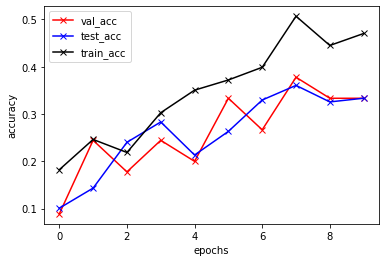

<Figure size 432x288 with 0 Axes>

In [94]:
plt.plot(time, val_acc_my_model, c='red', label='val_acc', marker='x')
plt.plot(time, test_acc_my_model, c='blue', label='test_acc', marker='x')
plt.plot(time, train_acc_my_model, c='black', label='train_acc', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.savefig('cnn.png')
# the below figure is not the final plot, this was the ouput when i ran the 
# model the second time. My report has my first plot. 

In [42]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# Set the model to evaluation mode
def scores(model, test_dl):
  """
  """
  model.eval()

# Initialize empty lists to store predictions and true labels
  y_pred = []
  y_true = []

  # Iterate over batches in the test dataloader
  for images, labels in test_dl:
      # Move images and labels to device (GPU/CPU)
      images = images.to(device)
      labels = labels.to(device)
      
      # Disable gradient computation to speed up inference
      with torch.no_grad():
          # Make predictions
          outputs = model(images)
          # Get predicted labels for each image in the batch
          _, predicted = torch.max(outputs.data, 1)
      
      # Append predicted and true labels to their respective lists
      y_pred.extend(predicted.cpu().numpy())
      y_true.extend(labels.cpu().numpy())

  # Print classification report and accuracy score
  print(classification_report(y_true, y_pred))
  print("Accuracy:", accuracy_score(y_true, y_pred))
  return accuracy_score(y_true, y_pred)

In [97]:
accurary_cnn = scores(model, test_dl)
print("Accuracy of CNN model without droupout:", accurary_cnn)

# the below accuracy is slighty lower than the first time I ran the training, 
# i got 0.38% accuracy as mentioned with the plot in the report the first time
# i ran it.

              precision    recall  f1-score   support

           0       0.40      0.70      0.51        30
           1       0.25      0.16      0.20        31
           2       0.25      0.08      0.12        26
           3       0.60      0.41      0.49        29
           4       0.29      0.14      0.19        36
           5       0.38      0.45      0.41        20
           6       0.22      0.52      0.31        21

    accuracy                           0.34       193
   macro avg       0.34      0.35      0.32       193
weighted avg       0.34      0.34      0.31       193

Accuracy: 0.33678756476683935
Accuracy of CNN model without droupout: 0.33678756476683935


# CNN model + dropout

In [76]:
class DropoutDogBreedClassificationCNN(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = nn.Sequential(
          

            nn.Conv2d(3, 16, 3, stride=1, padding=1),   # 224 * 224 * 16
            nn.ReLU(),                                   
            nn.BatchNorm2d(16),
            
            nn.Conv2d(16, 16, 3, stride=1, padding=1),  # 224 * 224 * 16
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # 112 * 112 * 16
            
            nn.Conv2d(16, 8, 3, stride=1, padding=1),   # 112 * 112 * 8
            nn.ReLU(), 
            nn.BatchNorm2d(8),
            
            nn.Conv2d(8, 8, 3, stride=1, padding=1),    # 112 * 112* 8
            nn.ReLU(),
            nn.MaxPool2d(2,2),                          # 56 * 56* 8
            nn.Dropout(0.5, inplace=False),
            nn.Flatten(),
            nn.Linear(56*56*8, 32),
            nn.ReLU(),
            nn.Linear(32, 7),
            nn.Dropout(0.5, inplace=False),
            nn.LogSoftmax(dim = 1),
        )
    
    def forward(self, xb):
        return self.network(xb)

In [77]:
dropout_model = DropoutDogBreedClassificationCNN()
dropout_model

DropoutDogBreedClassificationCNN(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout(p=0.5, inplace=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=25088, out_features=32, bias=True)
    (15): ReLU()
    (16): Linear(in_features=32, out_features=7, bias=True)
    (17): 

In [78]:
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
DBI_dl = DeviceDataLoader(DBI_dl, device)


# moving model to gpu
dropout_model = to_device(dropout_model, device);

cpu


In [79]:
evaluate(dropout_model, train_dl, val_dl, test_dl)  

{'val_loss': 1.9482029676437378,
 'val_acc': 0.15625,
 'test_acc': 0.11219952255487442,
 'train_acc': 0.20000000298023224}

In [80]:
history_dropout_model = fit_one_cycle(num_epochs, max_lr, dropout_model, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [0] : train_loss: 1.9666, val_loss: 1.9382, val_acc: 0.1556


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1] : train_loss: 1.9764, val_loss: 1.9456, val_acc: 0.1556


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2] : train_loss: 1.9162, val_loss: 1.9340, val_acc: 0.1556


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3] : train_loss: 1.8348, val_loss: 1.9049, val_acc: 0.2000


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4] : train_loss: 1.8852, val_loss: 1.8697, val_acc: 0.2444


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5] : train_loss: 1.8131, val_loss: 1.8218, val_acc: 0.2222


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6] : train_loss: 1.7677, val_loss: 1.7650, val_acc: 0.2444


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7] : train_loss: 1.7380, val_loss: 1.7386, val_acc: 0.2444


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8] : train_loss: 1.7150, val_loss: 1.7108, val_acc: 0.3333


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9] : train_loss: 1.7020, val_loss: 1.7040, val_acc: 0.3111


In [81]:
val_loss_dropout_model = []
train_loss_dropout_model = []
val_acc_dropout_model = []
test_acc_dropout_model = []
train_acc_dropout_model = []
time = list(range(len(history_dropout_model)))
for h in history_dropout_model:
    val_loss_dropout_model.append(h['val_loss'])
    train_loss_dropout_model.append(h['train_loss'])
    val_acc_dropout_model.append(h['val_acc'])
    test_acc_dropout_model.append(h['test_acc'])
    train_acc_dropout_model.append(h['train_acc'])
     

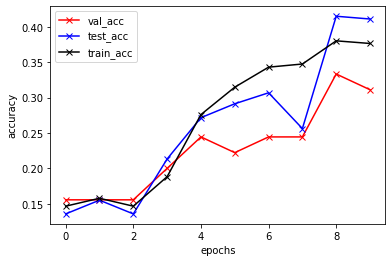

<Figure size 432x288 with 0 Axes>

In [85]:
plt.plot(time, val_acc_dropout_model, c='red', label='val_acc', marker='x')
plt.plot(time, test_acc_dropout_model, c='blue', label='test_acc', marker='x')
plt.plot(time, train_acc_dropout_model, c='black', label='train_acc', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.savefig('Figure 1.png')


In [84]:
accurary_cnn_dropout = scores(dropout_model, test_dl)
print("Accuracy of CNN model with droupout:", accurary_cnn_dropout)

              precision    recall  f1-score   support

           0       0.50      0.50      0.50        30
           1       0.43      0.65      0.52        31
           2       0.31      0.31      0.31        26
           3       0.46      0.72      0.56        29
           4       0.20      0.06      0.09        36
           5       0.00      0.00      0.00        20
           6       0.43      0.71      0.54        21

    accuracy                           0.42       193
   macro avg       0.33      0.42      0.36       193
weighted avg       0.34      0.42      0.36       193

Accuracy: 0.41968911917098445
Accuracy of CNN model with droupout: 0.41968911917098445


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Resnet 18 untrained

In [98]:
class DogBreedResnet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet18(pretrained=False)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [102]:
resnet18_model_untrained = DogBreedResnet18()
resnet18_model_untrained

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DogBreedResnet18(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [103]:
resnet18_model_untrained = to_device(resnet18_model_untrained, device);

In [104]:
evaluate(resnet18_model_untrained, train_dl, val_dl, test_dl)

{'val_loss': 2.009780168533325,
 'val_acc': 0.146577388048172,
 'test_acc': 0.13563701510429382,
 'train_acc': 0.15555556118488312}

In [105]:
history_resnet18_model = fit_one_cycle(num_epochs, max_lr, resnet18_model_untrained, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [0] : train_loss: 2.0201, val_loss: 1.9259, val_acc: 0.2444


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1] : train_loss: 1.9980, val_loss: 1.9238, val_acc: 0.2444


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2] : train_loss: 1.8513, val_loss: 2.2028, val_acc: 0.1111


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3] : train_loss: 1.7049, val_loss: 1.9026, val_acc: 0.2444


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4] : train_loss: 1.6869, val_loss: 1.8288, val_acc: 0.2444


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5] : train_loss: 1.6069, val_loss: 2.5123, val_acc: 0.1778


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6] : train_loss: 1.4945, val_loss: 1.7238, val_acc: 0.2667


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7] : train_loss: 1.4424, val_loss: 1.5893, val_acc: 0.3111


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8] : train_loss: 1.3492, val_loss: 1.6294, val_acc: 0.3333


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9] : train_loss: 1.3254, val_loss: 1.6192, val_acc: 0.3778


In [107]:
val_loss_resnet18_model = []
train_loss_resnet18_model = []
val_acc_resnet18_model = []
test_acc_resnet18_model = []
train_acc_resnet18_model = []
time = list(range(len(history_resnet18_model)))
for h in history_resnet18_model:
    val_loss_resnet18_model.append(h['val_loss'])
    train_loss_resnet18_model.append(h['train_loss'])
    val_acc_resnet18_model.append(h['val_acc'])
    test_acc_resnet18_model.append(h['test_acc'])
    train_acc_resnet18_model.append(h['train_acc'])
     

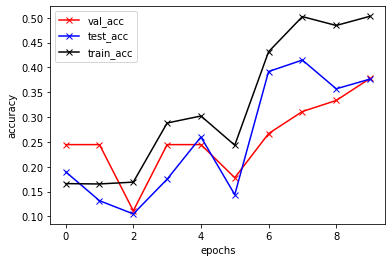

<Figure size 432x288 with 0 Axes>

In [108]:
plt.plot(time, val_acc_resnet18_model, c='red', label='val_acc', marker='x')
plt.plot(time, test_acc_resnet18_model, c='blue', label='test_acc', marker='x')
plt.plot(time, train_acc_resnet18_model, c='black', label='train_acc', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.savefig('Figure_resnet.png')

In [109]:
scores(resnet18_model_untrained, test_dl)

              precision    recall  f1-score   support

           0       0.40      0.60      0.48        30
           1       0.55      0.35      0.43        31
           2       0.25      0.23      0.24        26
           3       0.73      0.55      0.63        29
           4       0.33      0.06      0.10        36
           5       0.30      0.35      0.33        20
           6       0.30      0.76      0.43        21

    accuracy                           0.39       193
   macro avg       0.41      0.41      0.38       193
weighted avg       0.42      0.39      0.37       193

Accuracy: 0.39378238341968913


0.39378238341968913

# Task 3.b

In [110]:
accuracy_dbi = scores(resnet18_model_untrained, test_dl)

accuracy_sdd = scores(resnet18_model_untrained, SDD_dl)

              precision    recall  f1-score   support

           0       0.40      0.60      0.48        30
           1       0.55      0.35      0.43        31
           2       0.25      0.23      0.24        26
           3       0.73      0.55      0.63        29
           4       0.33      0.06      0.10        36
           5       0.30      0.35      0.33        20
           6       0.30      0.76      0.43        21

    accuracy                           0.39       193
   macro avg       0.41      0.41      0.38       193
weighted avg       0.42      0.39      0.37       193

Accuracy: 0.39378238341968913
              precision    recall  f1-score   support

           0       0.32      0.41      0.36       218
           1       0.30      0.21      0.25       150
           2       0.12      0.11      0.11       152
           3       0.38      0.43      0.40       150
           4       0.20      0.08      0.12       171
           5       0.28      0.24      0.26     

# Resnet18 Pretrained

In [34]:
class DogBreedResnet18Pretrained(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [35]:
resnet13_pretrained_model = DogBreedResnet18Pretrained()
resnet13_pretrained_model

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

DogBreedResnet18Pretrained(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [37]:
resnet13_pretrained_model = to_device(resnet13_pretrained_model, device);

In [38]:
num_epochs = 10
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [39]:
evaluate(resnet13_pretrained_model, train_dl, val_dl, test_dl)

{'val_loss': 2.3642003536224365,
 'val_acc': 0.1145833358168602,
 'test_acc': 0.13942307233810425,
 'train_acc': 0.15555556118488312}

In [40]:
history_resnet18_pretrained_model = fit_one_cycle(num_epochs, max_lr, resnet13_pretrained_model, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [0] : train_loss: 2.2222, val_loss: 1.8693, val_acc: 0.2222


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1] : train_loss: 1.3311, val_loss: 0.6501, val_acc: 0.8222


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.3238, val_loss: 0.1714, val_acc: 0.9556


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.1004, val_loss: 0.1889, val_acc: 0.9111


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.0654, val_loss: 0.0580, val_acc: 0.9778


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5] : train_loss: 0.0597, val_loss: 0.0571, val_acc: 0.9556


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6] : train_loss: 0.0435, val_loss: 0.1736, val_acc: 0.9333


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7] : train_loss: 0.0263, val_loss: 0.0922, val_acc: 0.9556


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8] : train_loss: 0.0450, val_loss: 0.0607, val_acc: 0.9778


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9] : train_loss: 0.0246, val_loss: 0.0641, val_acc: 0.9778


In [41]:
weights_fname = '/content/drive/MyDrive/csc420_a2/resnet18_pretained_model.pth'
torch.save(resnet13_pretrained_model.state_dict(), weights_fname)

In [46]:
torch.save(history_resnet18_pretrained_model, '/content/drive/MyDrive/csc420_a2/resnet18_training_history.pth')

In [42]:
accuracy_dbi_resnet13 = scores(resnet13_pretrained_model, test_dl)
print("Accuracy of Resnet18 on DBI test dataset :", accuracy_dbi_resnet13)
accuracy_sdd_resnet13 = scores(resnet13_pretrained_model, SDD_dl)
print("\n Accuracy of Resnet18 on SDD entire dataset :", accuracy_sdd_resnet13)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        31
           2       0.96      1.00      0.98        26
           3       1.00      0.86      0.93        29
           4       0.90      1.00      0.95        36
           5       1.00      1.00      1.00        20
           6       1.00      0.95      0.98        21

    accuracy                           0.97       193
   macro avg       0.98      0.97      0.98       193
weighted avg       0.98      0.97      0.97       193

Accuracy: 0.9740932642487047
Accuracy of Resnet18 on DBI test dataset : 0.9740932642487047
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       218
           1       0.92      0.88      0.90       150
           2       0.85      0.86      0.85       152
           3       0.98      0.81      0.88       150
           4       0.75      0.94      0.

In [43]:
history_resnet18_pretrained_model[0].keys()

dict_keys(['val_loss', 'val_acc', 'test_acc', 'train_acc', 'train_loss', 'lrs'])

In [44]:
val_loss_resnet18_model = []
train_loss_resnet18_model = []
val_acc_resnet18_model = []
test_acc_resnet18_model = []
train_acc_resnet18_model = []
time = list(range(len(history_resnet18_pretrained_model)))
for h in history_resnet18_pretrained_model:
    val_loss_resnet18_model.append(h['val_loss'])
    train_loss_resnet18_model.append(h['train_loss'])
    val_acc_resnet18_model.append(h['val_acc'])
    test_acc_resnet18_model.append(h['test_acc'])
    train_acc_resnet18_model.append(h['train_acc'])

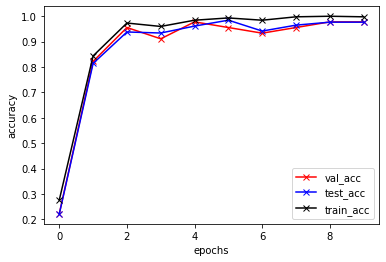

<Figure size 432x288 with 0 Axes>

In [45]:
plt.plot(time, val_acc_resnet18_model, c='red', label='val_acc', marker='x')
plt.plot(time, test_acc_resnet18_model, c='blue', label='test_acc', marker='x')
plt.plot(time, train_acc_resnet18_model, c='black', label='train_acc', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.savefig('Resnet18_pretrained.png')

# ResNet 32 Pretrained

In [24]:
def get_lr(optimizer):
      for param_group in optimizer.param_groups:
        return param_group['lr']
        

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, test_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        
        # Training phase
        model.train()       
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            
            # calculates gradients
            loss.backward()
            
            # check gradient clipping 
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            # perform gradient descent and modifies the weights
            optimizer.step()
            
            # reset the gradients
            optimizer.zero_grad()
            
            # record and update lr
            lrs.append(get_lr(optimizer))
            
            # modifies the lr value
            sched.step()
            
        # Validation phase
        result = evaluate(model, val_loader, train_loader, test_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
        
    return history
        
    

@torch.no_grad()
def evaluate(model, val_loader, train_loader, test_loader):
    # I added train accuracy here
    model.eval()
    val_outputs = [model.validation_step(batch) for batch in val_loader]
    train_outputs = [model.validation_step(batch) for batch in train_loader]
    test_outputs = [model.validation_step(batch) for batch in test_loader]

    output_val = model.validation_epoch_end(val_outputs)
    output_train = model.validation_epoch_end(train_outputs)
    output_test = model.validation_epoch_end(test_outputs)
    output = output_val
    output['test_acc'] = output_test['val_acc']
    output['train_acc'] = output_train['val_acc']
    return output


In [25]:
batch_size =16

# Create DataLoaders
resnext_train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
resnext_val_dl = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)
resnext_test_dl = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)
resnext_DBI_dl = DataLoader(DBIdataset, batch_size*2, num_workers=2, pin_memory=True)

In [26]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
resnext_train_dl = DeviceDataLoader(resnext_train_dl, device)
resnext_val_dl = DeviceDataLoader(resnext_val_dl, device)
resnext_test_dl = DeviceDataLoader(resnext_test_dl, device)
resnext_DBI_dl = DeviceDataLoader(resnext_DBI_dl, device)


cpu


In [27]:
class DogBreedResNeXt32Pretrained(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnext50_32x4d(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [28]:
resneXt32_pretrained_model = DogBreedResNeXt32Pretrained()
resneXt32_pretrained_model

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DogBreedResNeXt32Pretrained(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
       

In [29]:
resneXt32_pretrained_model = to_device(resneXt32_pretrained_model, device);

In [ ]:
num_epochs = 1
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

# I had to break the epochs and run it multiple times because I had only 12 gb ram on the google colab cpu
# It kept crashing so I kept saving my model and history after running each epoch.

In [74]:
history_resneXt32_pretrained_model = fit_one_cycle(num_epochs, max_lr, resneXt32_pretrained_model, resnext_train_dl, resnext_val_dl, resnext_val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.8338, val_loss: 0.1930, val_acc: 0.8918


In [35]:
num_epochs = 1
max_lr = 0.01
saved_history += fit_one_cycle(num_epochs, max_lr, resneXt32_pretrained_model, resnext_train_dl, resnext_val_dl, resnext_val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.7638, val_loss: 0.2019, val_acc: 0.9147


In [37]:
weights_fname = '/content/drive/MyDrive/csc420_a2/new_resneXt32_pretained_model.pth'
torch.save(resneXt32_pretrained_model.state_dict(), weights_fname)
torch.save(saved_history, '/content/drive/MyDrive/csc420_a2/resnet18_training_history.pth')

In [32]:
saved_history = torch.load('/content/drive/MyDrive/csc420_a2/resnet18_training_history.pth')

In [31]:
resneXt32_pretrained_model.load_state_dict(torch.load('/content/drive/MyDrive/csc420_a2/new_resneXt32_pretained_model.pth'))

<All keys matched successfully>

In [38]:
num_epochs = 1
max_lr = 0.01
saved_history += fit_one_cycle(num_epochs, max_lr, resneXt32_pretrained_model, resnext_train_dl, resnext_val_dl, resnext_val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.1550, val_loss: 0.1233, val_acc: 0.9688


In [41]:
num_epochs = 1
max_lr = 0.01
saved_history += fit_one_cycle(num_epochs, max_lr, resneXt32_pretrained_model, resnext_train_dl, resnext_val_dl, resnext_val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.2729, val_loss: 0.0952, val_acc: 0.9459


In [43]:
num_epochs = 1
max_lr = 0.01
saved_history += fit_one_cycle(num_epochs, max_lr, resneXt32_pretrained_model, resnext_train_dl, resnext_val_dl, resnext_val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.1655, val_loss: 0.1091, val_acc: 0.9231


In [33]:
num_epochs = 1
max_lr = 0.001
saved_history += fit_one_cycle(num_epochs, max_lr, resneXt32_pretrained_model, resnext_train_dl, resnext_val_dl, resnext_val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [0] : train_loss: 1.6406, val_loss: 1.1300, val_acc: 0.8137


In [36]:
num_epochs = 1
max_lr = 0.001
saved_history += fit_one_cycle(num_epochs, max_lr, resneXt32_pretrained_model, resnext_train_dl, resnext_val_dl, resnext_val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.9631, val_loss: 0.6133, val_acc: 1.0000


In [36]:
num_epochs = 1
max_lr = 0.001
saved_history += fit_one_cycle(num_epochs, max_lr, resneXt32_pretrained_model, resnext_train_dl, resnext_val_dl, resnext_val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.5729, val_loss: 0.3672, val_acc: 1.0000


In [33]:
num_epochs = 1
max_lr = 0.0001
saved_history += fit_one_cycle(num_epochs, max_lr, resneXt32_pretrained_model, resnext_train_dl, resnext_val_dl, resnext_val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.4096, val_loss: 0.3608, val_acc: 1.0000


In [36]:
num_epochs = 1
max_lr = 0.0001
saved_history += fit_one_cycle(num_epochs, max_lr, resneXt32_pretrained_model, resnext_train_dl, resnext_val_dl, resnext_val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.4160, val_loss: 0.3549, val_acc: 1.0000


In [35]:
weights_fname = '/content/drive/MyDrive/csc420_a2/3resneXt32_pretained_model.pth'
torch.save(resneXt32_pretrained_model.state_dict(), weights_fname)

In [43]:
accuracy_dbi_resnet34 = scores(resneXt32_pretrained_model, test_dl)

accuracy_sdd_resnet34 = scores(resneXt32_pretrained_model, SDD_dl)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        31
           2       1.00      1.00      1.00        26
           3       0.97      0.97      0.97        29
           4       0.95      0.97      0.96        36
           5       1.00      1.00      1.00        20
           6       1.00      0.95      0.98        21

    accuracy                           0.98       193
   macro avg       0.99      0.98      0.99       193
weighted avg       0.98      0.98      0.98       193

Accuracy: 0.9844559585492227
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       218
           1       0.95      0.92      0.94       150
           2       0.93      0.90      0.91       152
           3       0.99      0.77      0.86       150
           4       0.75      0.98      0.85       171
           5       0.95      0.95      0.95      

In [38]:
saved_history[0].keys()

dict_keys(['val_loss', 'val_acc', 'test_acc', 'train_acc', 'train_loss', 'lrs'])

In [58]:
val_loss_resnet32_model = []
train_loss_resnet32_model = []
val_acc_resnet32_model = []
test_acc_resnet32_model = []
train_acc_resnet32_model = []
time = list(range(len(saved_history)))
for h in saved_history:
    val_loss_resnet32_model.append(h['val_loss'])
    train_loss_resnet32_model.append(h['train_loss'])
    val_acc_resnet32_model.append(h['val_acc'])
    test_acc_resnet32_model.append(h['test_acc'])
    train_acc_resnet32_model.append(h['train_acc'])
print(val_acc_resnet32_model)
print(train_acc_resnet32_model)
print(test_acc_resnet32_model)

[0, 0.8918269276618958, 0.9146634340286255, 0.96875, 0.9459134340286255, 0.9230769276618958, 0.8137019276618958, 1.0, 1.0, 1.0, 1.0]
[0, 0.9759615659713745, 0.9615384340286255, 0.963942289352417, 0.9567307829856873, 0.9855769276618958, 0.8581730723381042, 0.9495192170143127, 0.9807692170143127, 0.9831730723381042, 0.9711538553237915]
[0, 0.8918269276618958, 0.9146634340286255, 0.96875, 0.9459134340286255, 0.9230769276618958, 0.8137019276618958, 1.0, 1.0, 1.0, 1.0]


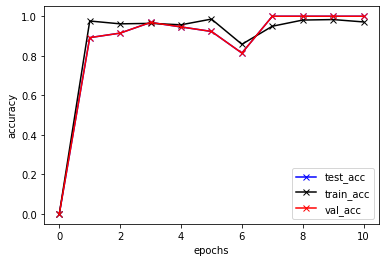

<Figure size 432x288 with 0 Axes>

In [60]:

plt.plot(time, test_acc_resnet32_model, c='blue', label='test_acc', marker='x')
plt.plot(time, train_acc_resnet32_model, c='black', label='train_acc', marker='x')
plt.plot(time, val_acc_resnet32_model, c='red', label='val_acc', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.savefig('Resnet34_pretrained.png')

# the below figure is not the final plot, this way the ouput where i ran the 
#model the second time. My report has my first plot.

# ResNet 34 Pretrained

In [47]:
class DogBreedResnet34Pretrained(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [48]:
resnet34_pretrained_model = DogBreedResnet34Pretrained()
resnet34_pretrained_model

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

DogBreedResnet34Pretrained(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [49]:
resnet34_pretrained_model = to_device(resnet34_pretrained_model, device);

In [50]:
evaluate(resnet34_pretrained_model, train_dl, val_dl, test_dl)

{'val_loss': 1.9000684022903442,
 'val_acc': 0.181547611951828,
 'test_acc': 0.16712740063667297,
 'train_acc': 0.2666666805744171}

In [ ]:
histroy_resnet34_pretrained_model = fit_one_cycle(num_epochs, max_lr, resnet34_pretrained_model, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [0] : train_loss: 1.8685, val_loss: 1.4296, val_acc: 0.5111


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.8854, val_loss: 0.1893, val_acc: 0.9333


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.1385, val_loss: 0.1075, val_acc: 0.9111


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.0628, val_loss: 0.0406, val_acc: 1.0000


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.0409, val_loss: 0.0390, val_acc: 0.9778


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5] : train_loss: 0.0159, val_loss: 0.0214, val_acc: 1.0000


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6] : train_loss: 0.0282, val_loss: 0.0251, val_acc: 1.0000


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7] : train_loss: 0.0124, val_loss: 0.0476, val_acc: 0.9778


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8] : train_loss: 0.0114, val_loss: 0.0528, val_acc: 0.9778


  0%|          | 0/7 [00:00<?, ?it/s]

In [56]:
weights_fname = '/content/drive/MyDrive/csc420_a2/resnet34_pretrained_model.pth'
torch.save(resnet34_pretrained_model.state_dict(), weights_fname)

In [57]:
torch.save(history_resnet18_pretrained_model, '/content/drive/MyDrive/csc420_a2/resnet34_training_history.pth')

In [58]:
check = DogBreedResnet34Pretrained()
check.load_state_dict(torch.load('resnet34_pretrained_model.pth'))
check.eval()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DogBreedResnet34Pretrained(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [59]:
accuracy_dbi_resnet34 = scores(resnet34_pretrained_model, test_dl)

accuracy_sdd_resnet34 = scores(resnet34_pretrained_model, SDD_dl)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        31
           2       1.00      1.00      1.00        26
           3       0.96      0.93      0.95        29
           4       0.95      0.97      0.96        36
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        21

    accuracy                           0.98       193
   macro avg       0.99      0.99      0.99       193
weighted avg       0.98      0.98      0.98       193

Accuracy: 0.9844559585492227
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       218
           1       0.97      0.91      0.94       150
           2       0.91      0.88      0.89       152
           3       0.94      0.90      0.92       150
           4       0.86      0.91      0.88       171
           5       0.86      0.98      0.92      

In [60]:
histroy_resnet34_pretrained_model[0].keys()

dict_keys(['val_loss', 'val_acc', 'test_acc', 'train_acc', 'train_loss', 'lrs'])

In [61]:
val_loss_resnet34_model = []
train_loss_resnet34_model = []
val_acc_resnet34_model = []
test_acc_resnet34_model = []
train_acc_resnet34_model = []
time = list(range(len(histroy_resnet34_pretrained_model)))
for h in histroy_resnet34_pretrained_model:
    val_loss_resnet34_model.append(h['val_loss'])
    train_loss_resnet34_model.append(h['train_loss'])
    val_acc_resnet34_model.append(h['val_acc'])
    test_acc_resnet34_model.append(h['test_acc'])
    train_acc_resnet34_model.append(h['train_acc'])

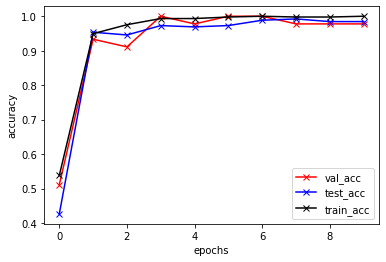

<Figure size 432x288 with 0 Axes>

In [62]:
plt.plot(time, val_acc_resnet34_model, c='red', label='val_acc', marker='x')
plt.plot(time, test_acc_resnet34_model, c='blue', label='test_acc', marker='x')
plt.plot(time, train_acc_resnet34_model, c='black', label='train_acc', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.savefig('Resnet34_pretrained.png')